<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/acrobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from autograd import jacobian, grad
from autograd.numpy import dot

import autograd.numpy as anp

class Acrobot:
    def __init__(self):
        self.m1 = 1.0   # Mass of link 1
        self.m2 = 1.0   # Mass of link 2
        self.l1 = 1.0   # Length of link 1
        self.l2 = 1.0   # Length of link 2
        self.lc1 = 0.5  # COM of link 1
        self.lc2 = 0.5  # COM of link 2
        self.I1 = 1.0   # Inertia of link 1
        self.I2 = 1.0   # Inertia of link 2
        self.g = 9.81   # Gravity

    def dynamics(self, x, u):
        θ1, θ2, dθ1, dθ2 = x
        m1, m2 = self.m1, self.m2
        l1, l2 = self.l1, self.l2
        lc1, lc2 = self.lc1, self.lc2
        I1, I2 = self.I1, self.I2
        g = self.g

        d1 = m1 * lc1**2 + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * anp.cos(θ2)) + I1 + I2
        d2 = m2 * (lc2**2 + l1 * lc2 * anp.cos(θ2)) + I2

        φ2 = m2 * lc2 * g * anp.cos(θ1 + θ2 - anp.pi/2)
        φ1 = (-m2 * l1 * lc2 * dθ2**2 * anp.sin(θ2)
              - 2 * m2 * l1 * lc2 * dθ2 * dθ1 * anp.sin(θ2)
              + (m1 * lc1 + m2 * l1) * g * anp.cos(θ1 - anp.pi/2)
              + φ2)

        D = anp.array([
            [d1, d2],
            [d2, m2 * lc2**2 + I2]
        ])
        C = anp.array([
            [-m2 * l1 * lc2 * anp.sin(θ2) * dθ2, -m2 * l1 * lc2 * anp.sin(θ2) * (dθ1 + dθ2)],
            [m2 * l1 * lc2 * anp.sin(θ2) * dθ1, 0.0]
        ])
        G = anp.array([
            φ1,
            φ2
        ])

        ddθ = anp.linalg.solve(D, anp.array([0.0, u]) - C @ anp.array([dθ1, dθ2]) - G)

        return anp.array([dθ1, dθ2, ddθ[0], ddθ[1]])

a = Acrobot()
h = 0.05

/tmp/ipython-input-13-255119541.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  un[k] = utraj[k] - α * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
/tmp/ipython-input-13-255119541.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  un[k] = utraj[k] - α * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
/tmp/ipython-input-13-255119541.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  un[k] = utraj[k] - α * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
/tmp/ip

Final cost: 414.70048051086235
Iterations: 81


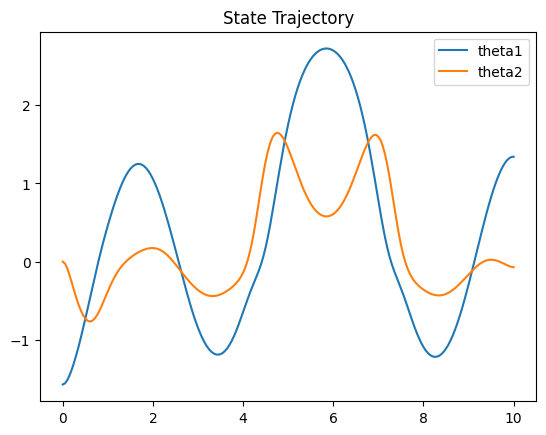

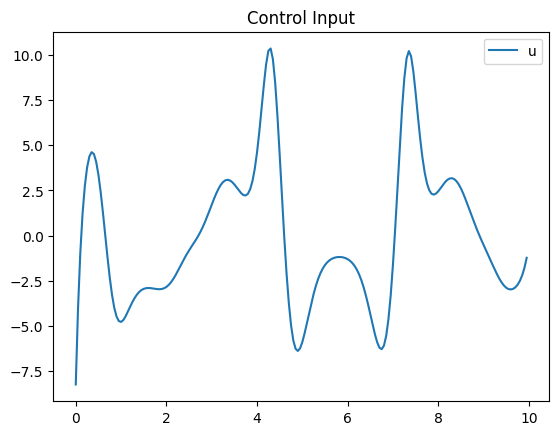

In [13]:
def dynamics_rk4(x, u):
    f1 = a.dynamics(x, u)
    f2 = a.dynamics(x + 0.5 * h * f1, u)
    f3 = a.dynamics(x + 0.5 * h * f2, u)
    f4 = a.dynamics(x + h * f3, u)
    return x + (h / 6.0) * (f1 + 2*f2 + 2*f3 + f4)

dfdx = jacobian(lambda x, u: dynamics_rk4(x, u), 0)
dfdu = jacobian(lambda x, u: dynamics_rk4(x, u), 1)

# Parameters
Nx, Nu = 4, 1
Tfinal = 10.0
Nt = int(Tfinal / h) + 1
thist = np.linspace(0, h*(Nt-1), Nt)

Q = np.diag([1.0, 1.0, 0.1, 0.1])
R = 0.01
Qn = 100.0 * np.eye(Nx)

x0 = np.array([-np.pi/2, 0, 0, 0])
xgoal = np.array([np.pi/2, 0, 0, 0])
xtraj = np.tile(x0[:, None], (1, Nt))
utraj = np.random.randn(Nt-1)

def stage_cost(x, u):
    return 0.5 * dot((x - xgoal), Q @ (x - xgoal)) + 0.5 * R * u * u

def terminal_cost(x):
    return 0.5 * dot((x - xgoal), Qn @ (x - xgoal))

def total_cost(xtraj, utraj):
    J = sum(stage_cost(xtraj[:, k], utraj[k]) for k in range(Nt - 1))
    J += terminal_cost(xtraj[:, -1])
    return J

# Initial rollout
for k in range(Nt - 1):
    xtraj[:, k+1] = dynamics_rk4(xtraj[:, k], utraj[k])

J = total_cost(xtraj, utraj)

# DDP structures
p = np.ones((Nx, Nt))
P = np.zeros((Nx, Nx, Nt))
d = np.ones(Nt - 1)
K = np.zeros((Nu, Nx, Nt - 1))

xn = np.zeros((Nx, Nt))
un = np.zeros(Nt - 1)

def backward_pass(xtraj, utraj, p, P, d, K):
    ΔJ = 0.0
    p[:, -1] = Qn @ (xtraj[:, -1] - xgoal)
    P[:, :, -1] = Qn

    for k in reversed(range(Nt - 1)):

        q = Q @ (xtraj[:, k] - xgoal)
        r = R * utraj[k]

        A = dfdx(xtraj[:, k], utraj[k])  # (Nx, Nx)
        B = dfdu(xtraj[:, k], utraj[k])  # (Nx, Nu)

        # Make sure B is 2D (Nx,1)
        if B.ndim == 1:
            B = B.reshape(-1, 1)

        gx = q + A.T @ p[:, k+1]
        gu = np.array([r]) + B.T @ p[:, k+1]  # gu shape: (1,)

        Gxx = Q + A.T @ P[:, :, k+1] @ A       # (Nx, Nx)
        Guu = R + B.T @ P[:, :, k+1] @ B   # (1,1)
        Gxu = A.T @ P[:, :, k+1] @ B           # (Nx, 1)
        Gux = Gxu.T                            # (1, Nx)

        # Regularize Guu to make positive definite if needed
        β = 0.1
        while np.linalg.cond(Guu) > 1e8:
            Gxx += β * np.eye(Nx)
            Guu += β * np.eye(1)
            β *= 2

        d[k] = np.linalg.solve(Guu, gu).item()          # d[k] shape: (1,)
        K[:, :, k] = np.linalg.solve(Guu, Gux)   # shape: (1, Nx)

        p[:, k] = (gx - (K[:, :, k].T @ gu).ravel()
           + d[k] * (K[:, :, k].T @ Guu).ravel()
           - (Gxu * d[k]).ravel())

        P[:, :, k] = (Gxx
                      + K[:, :, k].T @ Guu @ K[:, :, k]
                      - Gxu @ K[:, :, k]
                      - K[:, :, k].T @ Gux)

        ΔJ += gu.T * d[k]
        # q = Q @ (xtraj[:, k] - xgoal)
        # r = R * utraj[k]

        # A = dfdx(xtraj[:, k], utraj[k])
        # B = dfdu(xtraj[:, k], utraj[k])

        # gx = q + A.T @ p[:, k+1]
        # gu = r + B.T @ p[:, k+1]

        # Gxx = Q + A.T @ P[:, :, k+1] @ A
        # Guu = R + B.T @ P[:, :, k+1] @ B
        # Gxu = A.T @ P[:, :, k+1] @ B
        # Gux = Gxu.T

        # # Regularization
        # β = 0.1
        # while np.linalg.cond(Guu) > 1e8:
        #     Gxx += β * np.eye(Nx)
        #     Guu += β * np.eye(Nu)
        #     β *= 2

        # d[k] = np.linalg.solve(Guu, gu)
        # K[:, :, k] = np.linalg.solve(Guu, Gux)

        # p[:, k] = gx - K[:, :, k].T @ gu + K[:, :, k].T @ Guu @ d[k] - Gxu @ d[k]
        # P[:, :, k] = Gxx + K[:, :, k].T @ Guu @ K[:, :, k] - Gxu @ K[:, :, k] - K[:, :, k].T @ Gux

        # ΔJ += gu.T @ d[k]

    return ΔJ

# DDP loop
iter = 0
while np.max(np.abs(d)) > 1e-3:
    iter += 1
    ΔJ = backward_pass(xtraj, utraj, p, P, d, K)

    xn[:, 0] = xtraj[:, 0]
    α = 1.0

    for k in range(Nt - 1):
        un[k] = utraj[k] - α * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
        xn[:, k+1] = dynamics_rk4(xn[:, k], un[k])
    Jn = total_cost(xn, un)

    while np.isnan(Jn) or Jn > J - 1e-2 * α * ΔJ:
        α *= 0.5
        xn[:, 0] = xtraj[:, 0]
        for k in range(Nt - 1):
            un[k] = utraj[k] - α * d[k] - K[:, :, k] @ (xn[:, k] - xtraj[:, k])
            xn[:, k+1] = dynamics_rk4(xn[:, k], un[k])
        Jn = total_cost(xn, un)

    J = Jn
    xtraj = xn.copy()
    utraj = un.copy()

print("Final cost:", J)
print("Iterations:", iter)

# Plot
plt.figure()
plt.plot(thist, xtraj[0, :], label="theta1")
plt.plot(thist, xtraj[1, :], label="theta2")
plt.legend()
plt.title("State Trajectory")

plt.figure()
plt.plot(thist[:-1], utraj, label="u")
plt.title("Control Input")
plt.legend()
plt.show()
